Epoch 1/250  Train NLL: -3.2138e+00  Test NLL: -4.1314e+00
Epoch 2/250  Train NLL: -4.2624e+00  Test NLL: -4.2478e+00
Epoch 3/250  Train NLL: -4.3455e+00  Test NLL: -4.3011e+00
Epoch 4/250  Train NLL: -4.4013e+00  Test NLL: -4.4200e+00
Epoch 5/250  Train NLL: -4.4154e+00  Test NLL: -4.4219e+00
Epoch 6/250  Train NLL: -4.4520e+00  Test NLL: -4.4359e+00
Epoch 7/250  Train NLL: -4.4403e+00  Test NLL: -4.4754e+00
Epoch 8/250  Train NLL: -4.4627e+00  Test NLL: -4.4636e+00
Epoch 9/250  Train NLL: -4.4900e+00  Test NLL: -4.5026e+00
Epoch 10/250  Train NLL: -4.4799e+00  Test NLL: -4.4983e+00
Epoch 11/250  Train NLL: -4.5038e+00  Test NLL: -4.5243e+00
Epoch 12/250  Train NLL: -4.5179e+00  Test NLL: -4.4429e+00
Epoch 13/250  Train NLL: -4.5124e+00  Test NLL: -4.5064e+00
Epoch 14/250  Train NLL: -4.5103e+00  Test NLL: -4.5211e+00
Epoch 15/250  Train NLL: -4.5217e+00  Test NLL: -4.4797e+00
Epoch 16/250  Train NLL: -4.4982e+00  Test NLL: -4.5089e+00
Epoch 17/250  Train NLL: -4.5232e+00  Test NLL: -

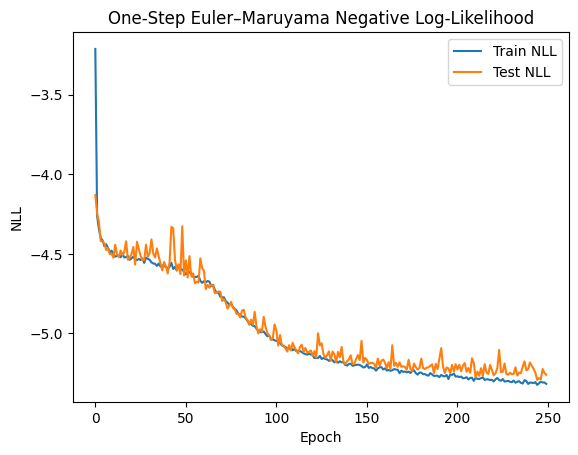

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt

# 1) Load the BTC surface tensor
surf = torch.load("btc_surfaces.pt")  # shape [T, N]
T, N = surf.shape

# Load dt tensor
dt_tensor = torch.load('dt.pt')

# 2) Train/Test split (80/20)
split = int(T * 0.8)
surf_train = surf[:split]
surf_test = surf[split:]

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)

# align dt
dt_train = dt_tensor[:split].to(device)
dt_test = dt_tensor[split:].to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(N).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 250
batch_size = 60


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(split - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (split - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")

# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()